In [1]:
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo 
from sklearn.linear_model import LinearRegression
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

In [2]:
columns=['tpep_pickup_datetime',
           'tpep_dropoff_datetime',
           'trip_distance',
           'pickup_longitude',
           'pickup_latitude',
           'dropoff_longitude',
           'dropoff_latitude',
           'total_amount']
df_2015 = pd.read_csv('yellow_tripdata_2015-01.csv', usecols=columns, nrows=1000000)
df_2016 = pd.read_csv('yellow_tripdata_2016-01.csv', usecols=columns, nrows=1000000)

In [3]:
df_2015.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30


### Data cleaning for pickup coordinates

In [4]:
#Removing pickup and dropoff coordinates which are 
def outlier_coordinates(df, test=False, predict=False):
    nrows = df.shape[0]
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    print("Number of rows removed due to wrong coordinates is {}".format(nrows - df.shape[0]))
    return df
df_2015 =  outlier_coordinates(df_2015)
df_2016 =  outlier_coordinates(df_2016)

Number of rows removed due to wrong coordinates is 20727
Number of rows removed due to wrong coordinates is 17791


In [5]:
# Minimum and maximum fare fixed by Yellow Taxi for the year 2015 is $2.5 to $52 for within the city trips
def clean_fare(df, test=False, predict=False):
    nrows = df.shape[0]
    if "total_amount" in list(df):
        df = df[df.total_amount.between(2.5, 52)]
    print("Number of rows removed due to out of range fare is {}".format(nrows - df.shape[0]))
    return df
df_2015 =  clean_fare(df_2015)
df_2016 =  clean_fare(df_2016)

Number of rows removed due to out of range fare is 26964
Number of rows removed due to out of range fare is 38826


###  Data cleaning for pickup coordinates

In [6]:
def clean_pcord(df):
    nrows = df.shape[0]
    df=df[(df['pickup_latitude']>=40.4774) & (df['pickup_latitude']<=40.9176)]
    df=df[(df['pickup_longitude']>=-74.2591) & (df['pickup_longitude']<=-73.7004)]
    print("Number of rows removed due to wrong coordinates is {}".format(nrows - df.shape[0]))
    return df
    
df_2015=clean_pcord(df_2015)
df_2016=clean_pcord(df_2016)
# Latitude and Longitude for NYC is 40.71427, -74.00597

Number of rows removed due to wrong coordinates is 87
Number of rows removed due to wrong coordinates is 67


###  Data cleaning for dropoff coordinates

In [7]:
def clean_dcord(df):
    nrows = df.shape[0]
    df=df[(df['dropoff_latitude']>=40.4774) & (df['dropoff_latitude']<=40.9176)]
    df=df[(df['dropoff_longitude']>=-74.2591) & (df['dropoff_longitude']<=-73.7004)]
    print("Number of rows removed due to wrong coordinates is {}".format(nrows - df.shape[0]))
    return df
    
df_2015=clean_dcord(df_2015)
df_2016=clean_dcord(df_2016)
# Latitude and Longitude for NYC is 40.71427, -74.00597

Number of rows removed due to wrong coordinates is 111
Number of rows removed due to wrong coordinates is 156


### Visualising pickup locations concentrated in NYC

In [8]:
df_2015_mp = df_2015[['pickup_latitude', 'pickup_longitude']].copy()

In [9]:
df_2015_mp

,pickup_latitude,pickup_longitude
0,40.750111,-73.993896
1,40.724243,-74.001648
2,40.802788,-73.963341
3,40.713818,-74.009087
4,40.762428,-73.971176
...,...,...
999994,40.722595,-73.991669
999995,40.739109,-73.990005
999996,40.772526,-73.952850
999997,40.755501,-73.979980


In [10]:
import folium
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

In [11]:
sample_locations = df_2015_mp.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

In [12]:
print(df_2015["pickup_latitude"].min())
print(df_2015["pickup_latitude"].max())

40.554603576660156
40.91633605957031


In [13]:
print(df_2015["pickup_longitude"].min())
print(df_2015["pickup_longitude"].max())

-74.24897003173827
-73.70068359375


In [14]:
def clean_trip_duration(df):
    # convert from object to datetime
    df['tpep_pickup_datetime']  = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime']  = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # copute the time diffrence between pickup & dropoff
    # to covert from nanosecondes to minutes we devide by 1000000000 then by 60
    # store trip_duratin column
    trip_duration = np.array(df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'])
    trip_duration = trip_duration/1000000000/60
    df['trip_duration'] = trip_duration.astype(float)
    
    # drop all records that have trip_duration > 2 hours and trip_duration <= 0
    nrows = df.shape[0]
    df.drop(df[(df['trip_duration'] > 120) | 
               (df['trip_duration'] <= 0)].index, inplace = True)
    print("Number of rows removed due to wrong trip_duration {}".format(nrows - df.shape[0]))
    return df
    
    
df_2015=clean_trip_duration(df_2015)
df_2016=clean_trip_duration(df_2016)
# trip duration column is created which displays the time in minutes

Number of rows removed due to wrong trip_duration 5096
Number of rows removed due to wrong trip_duration 7275


### Renaming pickup and dropoff datetime columns

In [15]:
df_2015=df_2015.rename(columns={'tpep_pickup_datetime': 'pickup_time'})
df_2016=df_2016.rename(columns={'tpep_pickup_datetime': 'pickup_time'})

In [16]:
df_2015=df_2015.rename(columns={'tpep_dropoff_datetime': 'dropoff_time'})
df_2016=df_2016.rename(columns={'tpep_dropoff_datetime': 'dropoff_time'})

In [17]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0


In [18]:
df_2016.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration
5,2016-01-01 00:00:00,2016-01-01 00:18:30,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.0
6,2016-01-01 00:00:00,2016-01-01 00:26:45,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.0
7,2016-01-01 00:00:01,2016-01-01 00:11:55,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.0
8,2016-01-01 00:00:02,2016-01-01 00:11:14,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.0
9,2016-01-01 00:00:02,2016-01-01 00:11:08,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.0


In [19]:
def clean_trip_distance(df):
    nrows = df.shape[0]
    df.drop(df[(df['trip_distance'] <= 0) | (df['trip_distance'] > 77.5)].index, inplace = True)
    print("Number of rows removed due to speed outliers {}".format(nrows - df.shape[0]))
    return df
    
df_2015=clean_trip_distance(df_2015)
df_2016=clean_trip_distance(df_2016)

Number of rows removed due to speed outliers 977
Number of rows removed due to speed outliers 793


In [20]:
def compute_speed(df):
    # computing Taxi speed average (mile/hour)
    df['speed'] = df['trip_distance']/df['trip_duration']*60
    return df
    
df_2015=compute_speed(df_2015)
df_2016=compute_speed(df_2016)    

In [21]:
def clean_speed(df):

    # Removing speed anomaly/outliers
    nrows = df.shape[0]
    df.drop(df[((df['speed'] <= 0) | (df['speed'] > 63.0))].index, inplace = True)
    print("Number of rows removed due to speed outliers {}".format(nrows - df.shape[0]))
    return df

df_2015=clean_speed(df_2015)
df_2016=clean_speed(df_2016)    

Number of rows removed due to speed outliers 70
Number of rows removed due to speed outliers 94


## K-Means with respect to longitude and latitude

In [22]:
from datetime import datetime, timedelta
from sklearn.cluster import MiniBatchKMeans, KMeans

#Clustering pickups
print("Getting clusters")
coord = df_2015[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)

print("Predicting clusters")
cluster_column = regions.predict(df_2015[["pickup_latitude", "pickup_longitude"]])
cluster_column_2016 = regions.predict(df_2016[["pickup_latitude", "pickup_longitude"]])
df_2015["pickup_cluster"] = cluster_column
df_2016["pickup_cluster"] = cluster_column_2016

Getting clusters
Predicting clusters


#### In this code snippet we are creating clusters based on pickup latitude and longitude. 30 clusters are created with 10,000 locations in each cluster using K means. Then we apply these clusters to the 2015 and 2016 dataset pickup latitude and longitude and assign it to the nearest cluster

In [23]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_cluster
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0,5.300000,29
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0,10.421053,23
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0,10.800000,7
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0,30.000000,0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0,9.473684,1


In [24]:
df_2016.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_cluster
5,2016-01-01 00:00:00,2016-01-01 00:18:30,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.0,18.400000,18
6,2016-01-01 00:00:00,2016-01-01 00:26:45,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.0,17.192308,19
7,2016-01-01 00:00:01,2016-01-01 00:11:55,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.0,6.545455,18
8,2016-01-01 00:00:02,2016-01-01 00:11:14,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.0,32.727273,5
9,2016-01-01 00:00:02,2016-01-01 00:11:08,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.0,17.509091,23


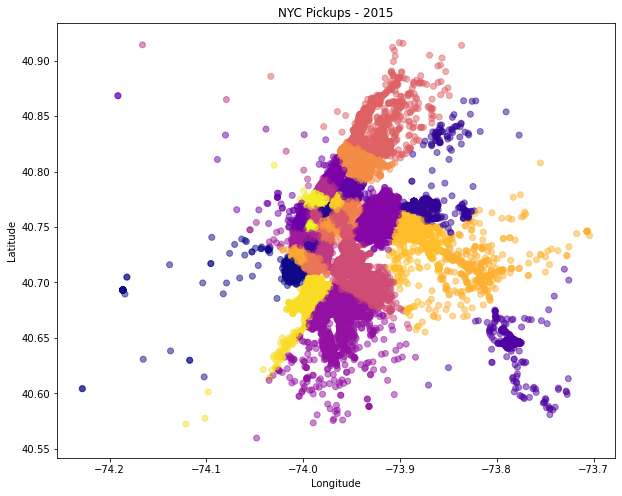

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_2015['pickup_longitude'], df_2015['pickup_latitude'], c=df_2015['pickup_cluster'], cmap='plasma', alpha=0.5)
ax.set_title('NYC Pickups - 2015')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

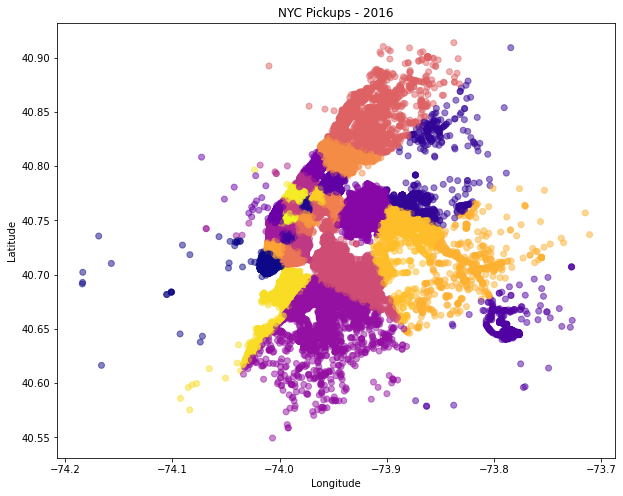

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_2016['pickup_longitude'], df_2016['pickup_latitude'], c=df_2016['pickup_cluster'], cmap='plasma', alpha=0.5)
ax.set_title('NYC Pickups - 2016')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### We are eliminating the minutes and seconds in the datetime and adding one hour to the time to round it off to the nearest hour

In [27]:
import pandas as pd
df_2015['pickup_time'] = pd.to_datetime(df_2015['pickup_time']).apply(lambda x : x.replace(minute=0, second=0) + pd.Timedelta(hours=1))
df_2016['pickup_time'] = pd.to_datetime(df_2016['pickup_time']).apply(lambda x : x.replace(minute=0, second=0) + pd.Timedelta(hours=1))

<b><p>This code is grouping the trip data by both the pickup time and pickup cluster, separately for the year 2015 and 2016.</p>
<p>This will be used to analyze the demand for taxi trips in each cluster at different times of the day and week. </p>
<p>Each row represents a unique combination of pickup time and pickup cluster, and the count column indicates the number of pickup locations that belong to that group</p></b>

In [36]:
print("Group by Cluster and time")
df2 = df_2015.groupby(['pickup_time','pickup_cluster']).size().reset_index(name='count')
df1 = df_2016.groupby(['pickup_time','pickup_cluster']).size().reset_index(name='count')

Group by Cluster and time


In [37]:
df2.head() #2015

,pickup_time,pickup_cluster,count
0,2015-01-01 01:00:00,0,86
1,2015-01-01 01:00:00,1,121
2,2015-01-01 01:00:00,2,11
3,2015-01-01 01:00:00,3,125
4,2015-01-01 01:00:00,4,18


In [38]:
df1.head() #2016

,pickup_time,pickup_cluster,count
0,2016-01-01 01:00:00,0,829
1,2016-01-01 01:00:00,1,1021
2,2016-01-01 01:00:00,2,70
3,2016-01-01 01:00:00,3,1090
4,2016-01-01 01:00:00,4,117


#### This scales the counts so that they range from 0 to 1, and represents the demand for taxi trips as a percentage of the maximum demand within each cluster and time period.

In [39]:
df2.head() #2015

,pickup_time,pickup_cluster,count
0,2015-01-01 01:00:00,0,86
1,2015-01-01 01:00:00,1,121
2,2015-01-01 01:00:00,2,11
3,2015-01-01 01:00:00,3,125
4,2015-01-01 01:00:00,4,18


Converting datetime to month,date,day of week and hour of the day for <b>2015</b> dataset
<br>
<b>Day of week starts from 0 representing Monday</b>

In [40]:
print("Getting month, date, hours, day of week")
df2['pickup_time'] = pd.to_datetime(df2['pickup_time'])
df2['month'] = df2['pickup_time'].dt.month
df2['date'] = df2['pickup_time'].dt.day
df2['dayofweek'] = df2['pickup_time'].dt.dayofweek
df2['hour'] = df2['pickup_time'].dt.hour

Getting month, date, hours, day of week


In [41]:
df2.head() #2015

,pickup_time,pickup_cluster,count,month,date,dayofweek,hour
0,2015-01-01 01:00:00,0,86,1,1,3,1
1,2015-01-01 01:00:00,1,121,1,1,3,1
2,2015-01-01 01:00:00,2,11,1,1,3,1
3,2015-01-01 01:00:00,3,125,1,1,3,1
4,2015-01-01 01:00:00,4,18,1,1,3,1


Converting datetime to month,date,day of week and hour of the day for <b>2016</b> dataset

In [42]:
df1['pickup_time'] = pd.to_datetime(df1['pickup_time'])
df1['month'] = df1['pickup_time'].dt.month
df1['date'] = df1['pickup_time'].dt.day
df1['dayofweek'] = df1['pickup_time'].dt.dayofweek
df1['hour'] = df1['pickup_time'].dt.hour

In [43]:
df1.head() #2016

,pickup_time,pickup_cluster,count,month,date,dayofweek,hour
0,2016-01-01 01:00:00,0,829,1,1,4,1
1,2016-01-01 01:00:00,1,1021,1,1,4,1
2,2016-01-01 01:00:00,2,70,1,1,4,1
3,2016-01-01 01:00:00,3,1090,1,1,4,1
4,2016-01-01 01:00:00,4,117,1,1,4,1


In [44]:
df2.drop(columns=['pickup_time'], inplace=True)
df1.drop(columns=['pickup_time'], inplace=True)

In [45]:
df2.head() #2015

,pickup_cluster,count,month,date,dayofweek,hour
0,0,86,1,1,3,1
1,1,121,1,1,3,1
2,2,11,1,1,3,1
3,3,125,1,1,3,1
4,4,18,1,1,3,1


In [46]:
df1.head() #2016

,pickup_cluster,count,month,date,dayofweek,hour
0,0,829,1,1,4,1
1,1,1021,1,1,4,1
2,2,70,1,1,4,1
3,3,1090,1,1,4,1
4,4,117,1,1,4,1


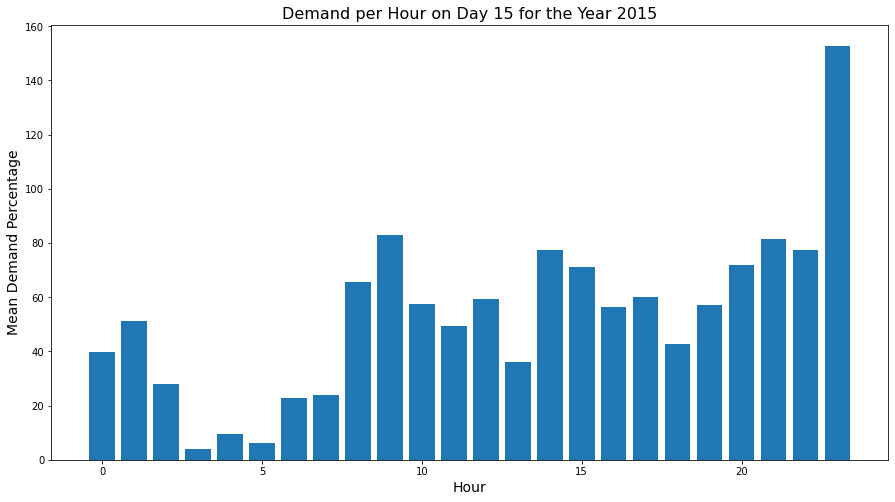

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
# Select the data for the day you're interested in (e.g., day 15)
day_data = df2[df2['date'] == 15]

# Group the data by hour and calculate the mean demand percentage for each hour
grouped = day_data.groupby('hour')['count'].mean()

# Create a bar chart using the grouped data
plt.bar(grouped.index, grouped.values)

# Set the title and axis labels
plt.title('Demand per Hour on Day 15 for the Year 2015', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Mean Demand Percentage', fontsize=14)

# Show the plot
plt.show()

In [48]:
print("Converting counts to demand percentage")
df2['count'] = df2['count'] / df2['count'].max()
df1['count'] = df1['count'] / df1['count'].max()

Converting counts to demand percentage


### Split data into train and test, X and y

In [49]:
# training X and y for train dataset
X_2015_1 = df2[['pickup_cluster', 'month', 'date', 'hour', 'dayofweek']]
y_2015_1= df2['count']

# training X and y for test dataset
X_2016_1 = df1[['pickup_cluster', 'month', 'date', 'hour', 'dayofweek']]
y_2016_1 = df1['count']

In [50]:
from sklearn.model_selection import train_test_split
X_2015, X_2016, y_2015, y_2016 = train_test_split(X_2015_1.values, y_2015_1.values, test_size=0.33, random_state=42)

#### The 2015 dataset is split into train and test set. Train set forms 2/3 of the dataset and Test set forms 1/3 of the dataset. Then this 1/3 test set of 2015 is used to predict demand for 2016 

### Models Training

<p> We will apply three Machine Learning models to predict the Taxi demand for the first montth of 2016</p>

#### Linear Regression

In [51]:
LReg = LinearRegression()
LReg.fit(X_2015,y_2015)
LReg_y_pred = LReg.predict(X_2016)

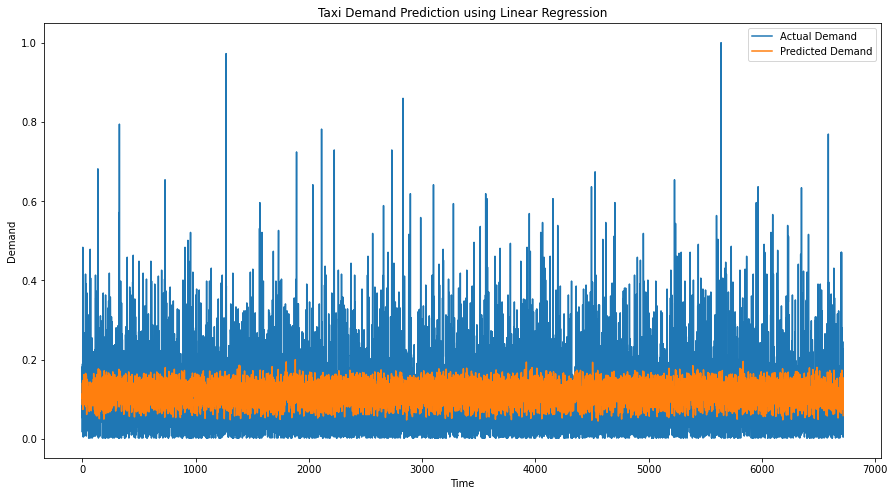

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
# Plot actual demand
plt.plot(y_2016, label='Actual Demand')

# Plot predicted demand
plt.plot(LReg_y_pred, label='Predicted Demand')

# Set axis labels and title
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Taxi Demand Prediction using Linear Regression')

# Add legend
plt.legend()

# Show plot
plt.show()


#### Random Forest

In [53]:
RFRegr = RandomForestRegressor()
RFRegr.fit(X_2015, y_2015)
RFRegr_y_pred = RFRegr.predict(X_2016)

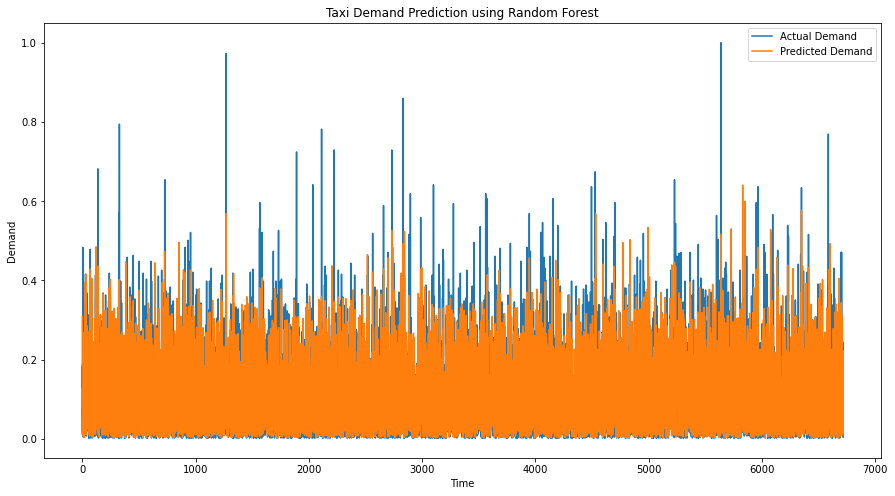

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
# Plot actual demand
plt.plot(y_2016, label='Actual Demand')

# Plot predicted demand
plt.plot(RFRegr_y_pred, label='Predicted Demand')

# Set axis labels and title
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Taxi Demand Prediction using Random Forest')

# Add legend
plt.legend()

# Show plot
plt.show()

#### XGBoost 

In [55]:
GBRegr = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
GBRegr.fit(X_2015, y_2015)
GBRegr_y_pred = GBRegr.predict(X_2016)

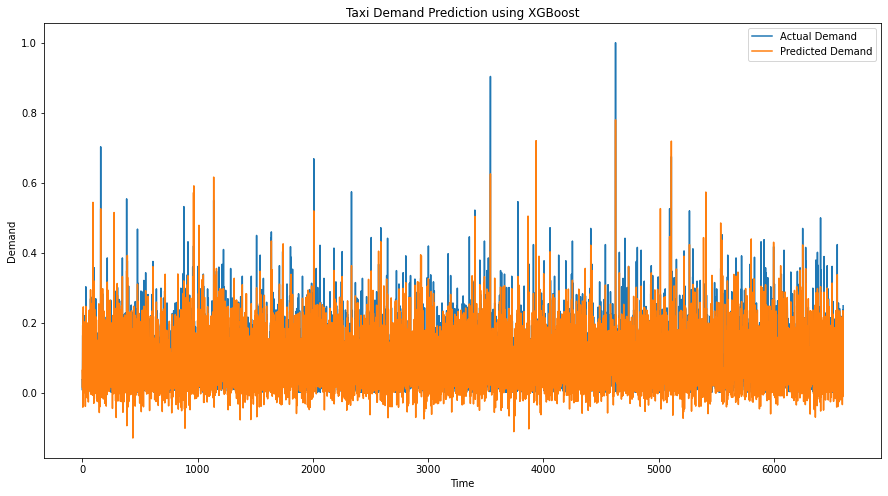

In [478]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
# Plot actual demand
plt.plot(y_2016, label='Actual Demand')

# Plot predicted demand
plt.plot(GBRegr_y_pred, label='Predicted Demand')

# Set axis labels and title
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Taxi Demand Prediction using XGBoost')

# Add legend
plt.legend()

# Show plot
plt.show()

### Model Evaluation

In [56]:
def model_evaluation(algorithm_name, X_Test, y_pred, y_true):
    
    # R-squared (R2) scroe
    r2 = r2_score(y_true, y_pred)
    # Mean square error(MSE)
    mse = mean_squared_error(y_true, y_pred)
    # Root mean square error(RMSE)
    rmse = math.sqrt(mse)
    print('R2 score: ',r2)
    print('MSE score: ',mse)
    print('RMSE score: ',rmse)

#### True value 

In [57]:
model_evaluation('y True',X_Test=X_2016, y_pred=y_2016, y_true=y_2016)

R2 score:  1.0
MSE score:  0.0
RMSE score:  0.0


#### Linear Regression

In [58]:
model_evaluation('Linear Regression',X_Test=X_2016, y_pred=LReg_y_pred, y_true=y_2016)

R2 score:  0.07160718000818889
MSE score:  0.012495869509337105
RMSE score:  0.11178492523295395


#### Random Forest

In [59]:
model_evaluation('Random Forest',X_Test=X_2016, y_pred=RFRegr_y_pred, y_true=y_2016)

R2 score:  0.725691044939863
MSE score:  0.0036921105310835146
RMSE score:  0.060762739660778255


#### Gradient Boosting

In [60]:
model_evaluation('Gradient Boosting',X_Test=X_2016, y_pred=GBRegr_y_pred, y_true=y_2016)

R2 score:  0.8577252625253303
MSE score:  0.0019149723217100577
RMSE score:  0.04376039672706428


## Testing on test dataset

In [61]:
LReg_y_pred = LReg.predict(X_2016_1)
RFRegr_y_pred = RFRegr.predict(X_2016_1)
GBRegr_y_pred = GBRegr.predict(X_2016_1)

In [62]:
print("True values")
model_evaluation('y True',X_Test=X_2016_1, y_pred=y_2016_1, y_true=y_2016_1)

True values
R2 score:  1.0
MSE score:  0.0
RMSE score:  0.0


In [63]:
print("Linear Regression")
model_evaluation('Linear Regression',X_Test=X_2016_1, y_pred=LReg_y_pred, y_true=y_2016_1)

Linear Regression
R2 score:  -0.02052150044390877
MSE score:  0.02299675808428478
RMSE score:  0.15164682022477352


In [64]:
print("Random Forest")
model_evaluation('Random Forest',X_Test=X_2016_1, y_pred=RFRegr_y_pred, y_true=y_2016_1)

Random Forest
R2 score:  0.4931001037306655
MSE score:  0.01142264448361384
RMSE score:  0.10687677242326249


In [65]:
print("Gradient Boosting")
model_evaluation('Gradient Boosting',X_Test=X_2016_1, y_pred=GBRegr_y_pred, y_true=y_2016_1)

Gradient Boosting
R2 score:  0.4756610608968913
MSE score:  0.011815621455774975
RMSE score:  0.10869968470871925
